# SRGAN
This notebook will contain demonstrations on how to train and use the SRGAN network. 

In [8]:
import imageio
import numpy as np

from skimage.transform import resize
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

from libs.srgan import SRGAN
from libs.util import plot_test_images

# 1. Loading Data
First we'll load some data to use

In [2]:
dataset = fetch_olivetti_faces("./data/olivetti_faces")
for i, img in enumerate(dataset.images):
    imageio.imwrite(f"./data/olivetti_faces/{i}.png", (img*255).astype(np.uint8))

## 1. Training

To train the SRGAN, we first instantiate the model

In [3]:
gan = SRGAN()

And then perform training, which has options for regularly outputting the result on a few test images, and which regularly saves the model weights (in data/weights/ directory). You should change:

* datapath: to the directory containing all your training images
* test_images: to a list of image paths for testing during training

During training, check out the ./images/samples/ directory for test sample results. Use the rest of the parameters to play with batch_size, how often to save the weights and perform testing, and how often to print progress. Here we only train the model on the limited olivetty faces dataset, and only for a short amount of epochs

In [4]:
gan.train(
    epochs=1000,
    dataname='olivetti',
    datapath='./data/olivetti_faces/',
    batch_size=1,
    test_images=[
        './data/olivetti_faces/0.png'
    ],
    test_frequency=100,
    test_path='./images/samples/',
    weight_path='./data/weights/',
    weight_frequency=100,
    print_frequency=100
)

>> Found 400 images in dataset


C:\Users\MAFG\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0/1000 | Time: 0:00:17.347621
>> Generator: loss=8.207e+01, model_3_loss=5.741e-01, model_1_loss=8.207e+01
>> Discriminator: loss=2.318e-01, acc=6.113e-01

Epoch 100/1000 | Time: 0:00:51.123415
>> Generator: loss=1.084e+01, model_3_loss=7.277e-03, model_1_loss=1.084e+01
>> Discriminator: loss=1.136e-04, acc=1.000e+00

Epoch 200/1000 | Time: 0:01:18.214827
>> Generator: loss=1.462e+00, model_3_loss=2.404e-03, model_1_loss=1.462e+00
>> Discriminator: loss=8.531e-06, acc=1.000e+00

Epoch 300/1000 | Time: 0:01:48.748940
>> Generator: loss=1.026e+00, model_3_loss=1.949e-03, model_1_loss=1.026e+00
>> Discriminator: loss=1.557e-05, acc=1.000e+00

Epoch 400/1000 | Time: 0:02:19.119570
>> Generator: loss=6.910e-01, model_3_loss=1.578e-03, model_1_loss=6.910e-01
>> Discriminator: loss=3.381e-06, acc=1.000e+00

Epoch 500/1000 | Time: 0:02:47.791386
>> Generator: loss=1.262e+00, model_3_loss=2.502e-03, model_1_loss=1.262e+00
>> Discriminator: loss=1.939e-05, acc=1.000e+00

Epoch 600/1000 | T

# 2. Testing
We have trained the network on imagenet for 100.000 iterations with a batch-size of 1. Below we show how to load these weights, and use them to create an SR version of a given image

In [4]:
gan.load_weights('./data/weights/imagenet_generator.h5', './data/weights/imagenet_discriminator.h5')

And then we can use the following utility function to take a test-image, super-resolve it, and then show the results

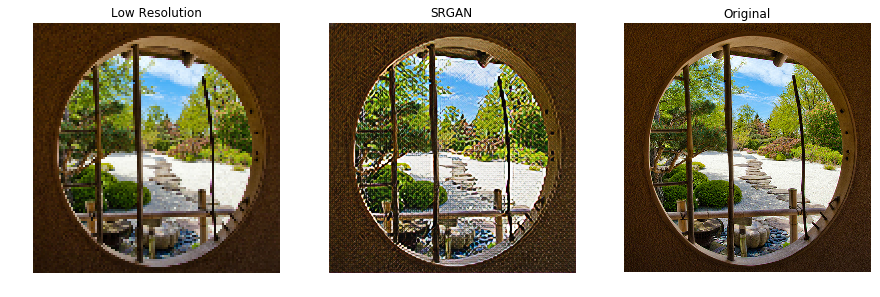

In [12]:
# Load image & scale it
img_hr = imageio.imread("./data/sample.jpg").astype(np.float) / 127.5 - 1

# Create a low-resolution version of it
lr_shape = (int(img_hr.shape[0]/4), int(img_hr.shape[1]/4))
img_lr = resize(img_hr, lr_shape, mode='constant')

# Predict high-resolution version (add batch dimension to image)
img_sr = gan.generator.predict(np.expand_dims(img_lr, 0))

# Remove batch dimension
img_sr = np.squeeze(img_sr, axis=0)

# Images and titles
images = {
    'Low Resolution': img_lr, 'SRGAN': img_sr, 'Original': img_hr
}

# Plot the images. Note: rescaling and using squeeze since we are getting batches of size 1                    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (title, img) in enumerate(images.items()):
    axes[i].imshow(0.5 * img + 0.5)
    axes[i].set_title(title)
    axes[i].axis('off')
plt.show()